Setup
=====

In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [2]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

In [15]:
def run_model_short(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    accuracies = []
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            #if training_now and (iter_cnt % print_every) == 0:
            #    print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
            #          .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            #iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        accuracies.append(total_correct)
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
    if plot_losses:
        plt.plot(accuracies)
        plt.grid(True)
        plt.title('Accuracies'.format(e+1))
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.show()
    return total_loss,total_correct

Starting model
============

* 7x7 conv 32 filters stride 1x1
* batch normalization
* max_pooling 2x2
* affine layer 5408->1024
* affine layer 1024->10

*Training*

Epoch 10, Overall loss = 0.129 and accuracy of 0.959

*Validation*

Epoch 1, Overall loss = 2.47 and accuracy of 0.653

In [11]:
def my_model(X,y,is_training):
    # convolutional layer with 32 7x7 filters
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    # a1 shape (?, 26, 26, 32)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    
    # batch normalization
    bn = tf.layers.batch_normalization(h1, axis=3, training=is_training)

    # max pooling 2x2 with stride 2
    # max_pool shape (?, 13, 13, 32)
    max_pool = tf.nn.max_pool(bn, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')

    # affine layer with 1024 output units and relu
    W1 = tf.get_variable("W1", shape=[5408, 1024])
    b1 = tf.get_variable("b1", shape=[1024]) 
    max_pool_flat = tf.reshape(max_pool,[-1,5408])
    affine1 = tf.matmul(max_pool_flat, W1) + b1
    h2 = tf.nn.relu(affine1)
    
    # affine layer 2 with 10 outputs
    W2 = tf.get_variable("W2", shape=[1024, 10])
    b2 = tf.get_variable("b2", shape=[10]) 
    y_out = tf.matmul(h2, W2) + b2
    
    return y_out

Sandbox
=======

```
out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2]))
```

In [12]:
input_height = input_width = 32
strides = 2
for i in range(1, 10):
    out_height = math.ceil(float(input_height - i + 1) / float (strides))
    out_width = math.ceil(float(input_width - i + 1) / float (strides))
    print("Filter: {}\t{}, {}".format(i, out_width, out_height))

Filter: 1	16, 16
Filter: 2	16, 16
Filter: 3	15, 15
Filter: 4	15, 15
Filter: 5	14, 14
Filter: 6	14, 14
Filter: 7	13, 13
Filter: 8	13, 13
Filter: 9	12, 12


In [13]:
tf.reset_default_graph()

def sandbox_model(X,y,is_training, filter_size):  
    # 32 layer conv2d with 3x3 filters
    h1 = tf.layers.conv2d(X, 32, [filter_size, filter_size], strides=(1, 1), activation=tf.nn.relu)
    
    # batch normalization
    bn = tf.layers.batch_normalization(h1, axis=3, training=is_training)

    # max pooling 2x2 with stride 2
    # max_pool shape (?, 15, 15, 32)
    max_pool = tf.layers.max_pooling2d(bn, [2, 2], [2, 2])

    # affine layer with 1024 output units and relu
    inputs = max_pool.shape[1] * max_pool.shape[2] * max_pool.shape[3]
    max_pool_flat = tf.reshape(max_pool,[-1,inputs])
    h2 = tf.layers.dense(max_pool_flat, 1024, activation=tf.nn.relu)
    
    # affine layer 2 with 10 outputs  
    y_out = tf.layers.dense(h2, 10, activation=None)
    
    return y_out

Test model
==========

Filter size: 1
Training
Epoch 1, Overall loss = 1.98 and accuracy of 0.407
Epoch 2, Overall loss = 1.38 and accuracy of 0.521
Epoch 3, Overall loss = 1.24 and accuracy of 0.573
Epoch 4, Overall loss = 1.13 and accuracy of 0.608
Epoch 5, Overall loss = 1.03 and accuracy of 0.644
Epoch 6, Overall loss = 0.94 and accuracy of 0.678
Epoch 7, Overall loss = 0.859 and accuracy of 0.706
Epoch 8, Overall loss = 0.783 and accuracy of 0.736
Epoch 9, Overall loss = 0.709 and accuracy of 0.76
Epoch 10, Overall loss = 0.641 and accuracy of 0.786


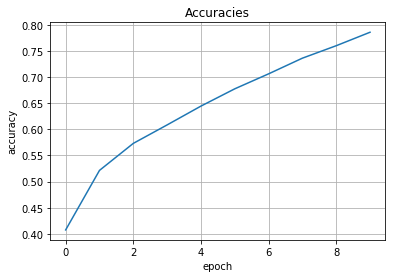

Validation
Epoch 1, Overall loss = 1.76 and accuracy of 0.537
Filter size: 2
Training
Epoch 1, Overall loss = 1.67 and accuracy of 0.466
Epoch 2, Overall loss = 1.09 and accuracy of 0.626
Epoch 3, Overall loss = 0.793 and accuracy of 0.732
Epoch 4, Overall loss = 0.555 and accuracy of 0.813
Epoch 5, Overall loss = 0.384 and accuracy of 0.871
Epoch 6, Overall loss = 0.275 and accuracy of 0.909
Epoch 7, Overall loss = 0.209 and accuracy of 0.93
Epoch 8, Overall loss = 0.172 and accuracy of 0.943
Epoch 9, Overall loss = 0.145 and accuracy of 0.954
Epoch 10, Overall loss = 0.129 and accuracy of 0.96


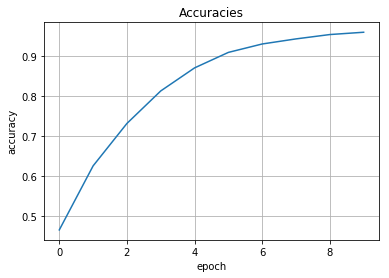

Validation
Epoch 1, Overall loss = 2.84 and accuracy of 0.631
Filter size: 3
Training
Epoch 1, Overall loss = 1.64 and accuracy of 0.471
Epoch 2, Overall loss = 1.06 and accuracy of 0.641
Epoch 3, Overall loss = 0.73 and accuracy of 0.753
Epoch 4, Overall loss = 0.475 and accuracy of 0.841
Epoch 5, Overall loss = 0.323 and accuracy of 0.891
Epoch 6, Overall loss = 0.236 and accuracy of 0.921
Epoch 7, Overall loss = 0.192 and accuracy of 0.938
Epoch 8, Overall loss = 0.159 and accuracy of 0.949
Epoch 9, Overall loss = 0.14 and accuracy of 0.956
Epoch 10, Overall loss = 0.122 and accuracy of 0.962


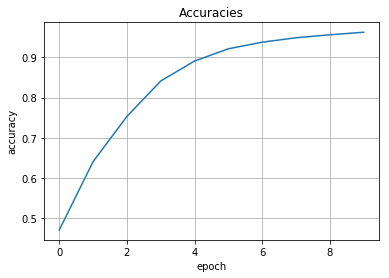

Validation
Epoch 1, Overall loss = 2.97 and accuracy of 0.636
Filter size: 4
Training
Epoch 1, Overall loss = 1.62 and accuracy of 0.47
Epoch 2, Overall loss = 1.05 and accuracy of 0.643
Epoch 3, Overall loss = 0.725 and accuracy of 0.755
Epoch 4, Overall loss = 0.479 and accuracy of 0.839
Epoch 5, Overall loss = 0.324 and accuracy of 0.89
Epoch 6, Overall loss = 0.236 and accuracy of 0.921
Epoch 7, Overall loss = 0.187 and accuracy of 0.939
Epoch 8, Overall loss = 0.162 and accuracy of 0.948
Epoch 9, Overall loss = 0.136 and accuracy of 0.957
Epoch 10, Overall loss = 0.118 and accuracy of 0.963


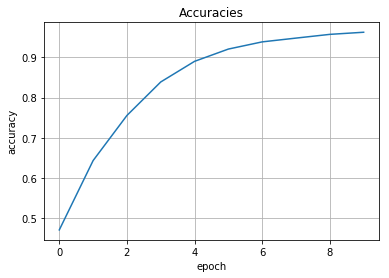

Validation
Epoch 1, Overall loss = 2.96 and accuracy of 0.611
Filter size: 5
Training
Epoch 1, Overall loss = 1.66 and accuracy of 0.459
Epoch 2, Overall loss = 1.09 and accuracy of 0.628
Epoch 3, Overall loss = 0.772 and accuracy of 0.739
Epoch 4, Overall loss = 0.522 and accuracy of 0.825
Epoch 5, Overall loss = 0.351 and accuracy of 0.883
Epoch 6, Overall loss = 0.254 and accuracy of 0.915
Epoch 7, Overall loss = 0.203 and accuracy of 0.933
Epoch 8, Overall loss = 0.164 and accuracy of 0.947
Epoch 9, Overall loss = 0.147 and accuracy of 0.953
Epoch 10, Overall loss = 0.131 and accuracy of 0.959


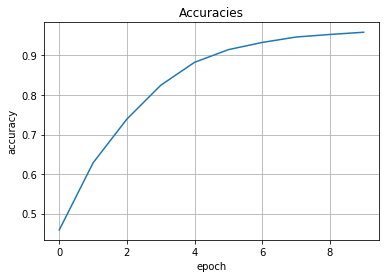

Validation
Epoch 1, Overall loss = 2.39 and accuracy of 0.656
Filter size: 6
Training
Epoch 1, Overall loss = 1.67 and accuracy of 0.448
Epoch 2, Overall loss = 1.11 and accuracy of 0.622
Epoch 3, Overall loss = 0.8 and accuracy of 0.73
Epoch 4, Overall loss = 0.548 and accuracy of 0.816
Epoch 5, Overall loss = 0.372 and accuracy of 0.874
Epoch 6, Overall loss = 0.268 and accuracy of 0.909
Epoch 7, Overall loss = 0.207 and accuracy of 0.932
Epoch 8, Overall loss = 0.171 and accuracy of 0.944
Epoch 9, Overall loss = 0.148 and accuracy of 0.953
Epoch 10, Overall loss = 0.128 and accuracy of 0.96


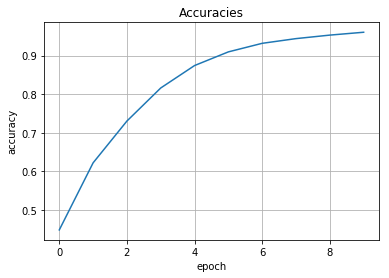

Validation
Epoch 1, Overall loss = 2.57 and accuracy of 0.619
Filter size: 7
Training
Epoch 1, Overall loss = 1.66 and accuracy of 0.456
Epoch 2, Overall loss = 1.11 and accuracy of 0.62
Epoch 3, Overall loss = 0.81 and accuracy of 0.727
Epoch 4, Overall loss = 0.555 and accuracy of 0.814
Epoch 5, Overall loss = 0.373 and accuracy of 0.874
Epoch 6, Overall loss = 0.273 and accuracy of 0.908
Epoch 7, Overall loss = 0.22 and accuracy of 0.928
Epoch 8, Overall loss = 0.177 and accuracy of 0.942
Epoch 9, Overall loss = 0.147 and accuracy of 0.952
Epoch 10, Overall loss = 0.131 and accuracy of 0.958


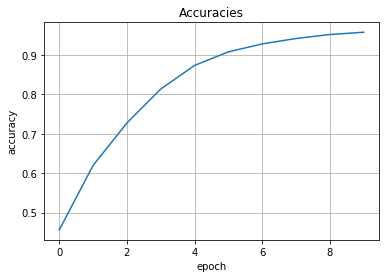

Validation
Epoch 1, Overall loss = 2.56 and accuracy of 0.64
Filter size: 8
Training
Epoch 1, Overall loss = 1.69 and accuracy of 0.445
Epoch 2, Overall loss = 1.15 and accuracy of 0.608
Epoch 3, Overall loss = 0.851 and accuracy of 0.712
Epoch 4, Overall loss = 0.6 and accuracy of 0.798
Epoch 5, Overall loss = 0.421 and accuracy of 0.857
Epoch 6, Overall loss = 0.3 and accuracy of 0.898
Epoch 7, Overall loss = 0.236 and accuracy of 0.921
Epoch 8, Overall loss = 0.2 and accuracy of 0.933
Epoch 9, Overall loss = 0.166 and accuracy of 0.945
Epoch 10, Overall loss = 0.145 and accuracy of 0.952


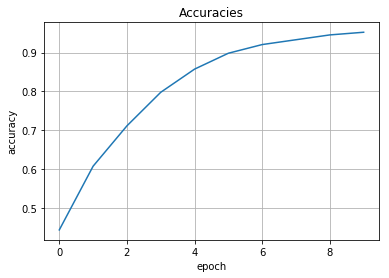

Validation
Epoch 1, Overall loss = 2.52 and accuracy of 0.622
Filter size: 9
Training
Epoch 1, Overall loss = 1.7 and accuracy of 0.445
Epoch 2, Overall loss = 1.15 and accuracy of 0.608
Epoch 3, Overall loss = 0.851 and accuracy of 0.712
Epoch 4, Overall loss = 0.607 and accuracy of 0.797
Epoch 5, Overall loss = 0.425 and accuracy of 0.857
Epoch 6, Overall loss = 0.306 and accuracy of 0.896
Epoch 7, Overall loss = 0.241 and accuracy of 0.92
Epoch 8, Overall loss = 0.195 and accuracy of 0.935
Epoch 9, Overall loss = 0.164 and accuracy of 0.947
Epoch 10, Overall loss = 0.15 and accuracy of 0.951


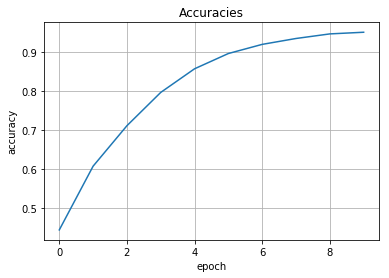

Validation
Epoch 1, Overall loss = 2.67 and accuracy of 0.627
Filter size: 10
Training
Epoch 1, Overall loss = 1.74 and accuracy of 0.43
Epoch 2, Overall loss = 1.2 and accuracy of 0.586
Epoch 3, Overall loss = 0.929 and accuracy of 0.686
Epoch 4, Overall loss = 0.696 and accuracy of 0.768
Epoch 5, Overall loss = 0.498 and accuracy of 0.834
Epoch 6, Overall loss = 0.359 and accuracy of 0.879
Epoch 7, Overall loss = 0.28 and accuracy of 0.905
Epoch 8, Overall loss = 0.232 and accuracy of 0.924
Epoch 9, Overall loss = 0.198 and accuracy of 0.934
Epoch 10, Overall loss = 0.164 and accuracy of 0.944


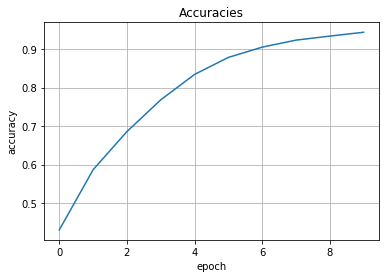

Validation
Epoch 1, Overall loss = 2.42 and accuracy of 0.624
Filter size: 11
Training
Epoch 1, Overall loss = 1.73 and accuracy of 0.433
Epoch 2, Overall loss = 1.21 and accuracy of 0.584
Epoch 3, Overall loss = 0.935 and accuracy of 0.68
Epoch 4, Overall loss = 0.707 and accuracy of 0.76
Epoch 5, Overall loss = 0.517 and accuracy of 0.826
Epoch 6, Overall loss = 0.383 and accuracy of 0.871
Epoch 7, Overall loss = 0.291 and accuracy of 0.903
Epoch 8, Overall loss = 0.231 and accuracy of 0.922
Epoch 9, Overall loss = 0.199 and accuracy of 0.933
Epoch 10, Overall loss = 0.171 and accuracy of 0.942


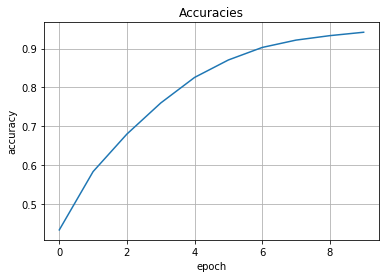

Validation
Epoch 1, Overall loss = 2.48 and accuracy of 0.61


In [16]:
model_func = sandbox_model

for filter_size in range(1, 12):
    print("==============================================================")
    print("Filter size: " + str(filter_size))
    print("==============================================================")
    tf.reset_default_graph()

    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)

    y_out = model_func(X,y,is_training, filter_size)
    total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),y_out)
    mean_loss = tf.reduce_mean(total_loss)
    optimizer = tf.train.RMSPropOptimizer(1e-3)

    # batch normalization in tensorflow requires this extra dependency
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        train_step = optimizer.minimize(mean_loss)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model_short(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)